In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/magdalenastrauss/Documents/GPclust')
sys.path.append('/Users/magdalenastrauss/Documents/GPy')
sys.path.append('/anaconda/lib/python3.6/site-packages')
import numpy as np
import os
import GPy
import GPclust

Change the root directory below for your system

In [24]:
rootdir = '../scratch'#where 
def datafile(filename):
    return os.path.join(rootdir, filename)

Define functions to load data

In [25]:
def load_data(expr_file, times_file):
    expression = np.loadtxt(datafile(expr_file), delimiter=',')
    times = np.loadtxt(datafile(times_file), delimiter=',')
    # remove genes with no variance
    std = expression.std(axis=1)
    nonzero_var = std != 0.
    expression = expression[nonzero_var]
    # normalize data row-wise
    expression -= expression.mean(axis=1)[:, np.newaxis]
    expression /= std[nonzero_var, np.newaxis]
    return expression, times

Define function to fit GPClust model

In [26]:
def fit_gpclust(underlying_variance, underlying_lengthscale,
                corruption_variance, corruption_lengthscale,
                noise_variance,
                expression,
                times,
                kernel=GPy.kern.Matern52,
                K=20,
                alpha=1.0):
    k_underlying = kernel(input_dim=1,
                          variance=underlying_variance,
                          lengthscale=underlying_lengthscale)
    k_corruption = \
        kernel(input_dim=1,
               variance=corruption_variance,
               lengthscale=corruption_lengthscale) + \
        GPy.kern.White(1, variance=noise_variance)
    m = GPclust.MOHGP(times.reshape(-1,1), k_underlying, k_corruption,
                      expression, K=20, prior_Z='DP', alpha=1.0)
    m.hyperparam_opt_interval = 1000 # how often to optimize the hyperparameters
    m.hyperparam_opt_args['messages'] = False # don't print optimization messages
    m.optimize()
    m.systematic_splits(verbose=False)  
    m.reorder()  # move biggest clusters to the top
    print(m)
    return m

In [67]:
def print_cluster_allocations(phi): 
    clusterAllocVector = np.zeros((1,phi.shape[0])) 
    for j in range(1,phi.shape[1]+1):
        k = j-1
        clusterAllocVector[0,np.argmax(phi,1)==k] = j
    return clusterAllocVector     

# Shalek - deLorean

In [69]:
#The following may need several restarts to avoid local optima or solutions with all genes in only one cluster etc. 
#Due to this instability, it is possible that the clustering solution computed here is different from the one used in
#the GPseudoClust paper, which was based on several reruns to obtain a solution avoiding very short length scales, all genes 
#in only one cluster etc.
shalek_expr, shalek_deLorean_times = load_data("deLoreanShalek.csv", "deLoreanTShalek.csv")
m_shalek_deLorean = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=12.,
                corruption_variance=.1,
                corruption_lengthscale=12.,
                noise_variance=.05,
                expression=shalek_expr,
                times=shalek_slicer_times)

iteration 1 bound=-80284.9767815 grad=28972.5725053, beta=0
iteration 2 bound=-79986.7946831 grad=1572.64707129, beta=0.0625313708842
iteration 3 bound=-79914.1838144 grad=602.002490036, beta=0.921087170782
iteration 4 bound=-79306.2150596 grad=217.724383457, beta=0.368456221949
iteration 5 bound=-79165.5052233 grad=6.18447409916, beta=0.225142430049
iteration 7 bound=-79106.6110166 grad=132.124410684, beta=32.296885837
iteration 9 bound=-85225.3749504 grad=66.2483989333, beta=0.0
iteration 10 bound=-80490.3036374 grad=1.38435851255e-34, beta=0.0
vb converged (gtol)
iteration 11 bound=-16627.9615414 grad=67.8255012352, beta=1.25347958612e+37
iteration 13 bound=-17550.0524912 grad=0.0, beta=-0.0
vb converged (gtol)
iteration 14 bound=-16712.6734235 grad=33.1298422282, beta=0.0


 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:divide by zero encountered in double_scalars


iteration 15 bound=-16712.6734235 grad=3.75475531726, beta=0.0
vb converged (ftol)
iteration 16 bound=-16668.8045569 grad=3.75475531726, beta=0.999999999999
iteration 17 bound=-16668.8045569 grad=3.75475531726, beta=0.0


 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:invalid value encountered in double_scalars


vb converged (ftol)
iteration 18 bound=-16651.3145293 grad=3.75475531726, beta=1.0
iteration 19 bound=-16651.3145293 grad=3.75475531726, beta=0.0
vb converged (ftol)
iteration 20 bound=-16651.1116962 grad=3.75475531726, beta=0.999999999999
iteration 21 bound=-16651.1116962 grad=3.75475531726, beta=0.0
vb converged (ftol)
iteration 22 bound=-16648.9188806 grad=3.75475531726, beta=1.0
iteration 23 bound=-16648.9188806 grad=3.75475531726, beta=0.0
vb converged (ftol)
iteration 24 bound=-16645.1500655 grad=3.75475531726, beta=0.999999999994
iteration 25 bound=-16645.1500655 grad=3.75475531726, beta=0.0
vb converged (ftol)

Name : MOHGP
Objective : 16645.14928372767
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  MOHGP.                 |           value  |  constraints  |  priors
  Mat52.variance         |   0.12151082215  |      +ve      |        
  Mat52.lengthscale      |   3.09076346479  |      +ve      |        
  sum.Mat52.variance     |  0.

In [68]:
print_cluster_allocations(m_shalek_deLorean.phi)

array([[ 2.,  1.,  3.,  1.,  2.,  1.,  1.,  4.,  1.,  1.,  3.,  1.,  1.,
         1.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  4.,  1.,  2.,
         2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,
         5.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
         1.,  1.,  1.,  5.,  2.,  1.,  3.,  4.,  1.,  4.,  2.,  1.,  3.,
         1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  1.]])

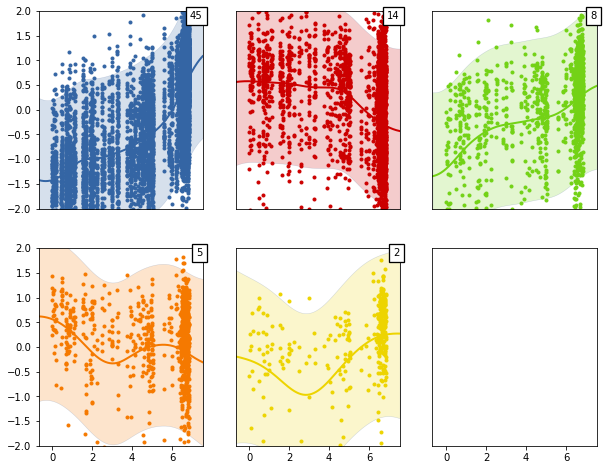

In [28]:
plt.figure(figsize=(10,8))
m_shalek_slicer.plot(on_subplots=True, colour=True, in_a_row=False, newfig=False,
                     min_in_cluster=1, joined=False, ylim=(-2,2))

# Shalek - SLICER

In [48]:
#The following may need several restarts to avoid local optima or solutions with all genes in only one cluster etc. 
#Due to this instability, it is possible that the clustering solution computed here is different from the one used in
#the GPseudoClust paper, which was based on several reruns to obtain a solution avoiding very short length scales, all genes 
#in only one cluster etc.
shalek_expr, shalek_slicer_times = load_data("ShalekSLICER.csv", "pseudoTimesSLICER.csv")
m_shalek_slicer = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=12.,
                corruption_variance=.1,
                corruption_lengthscale=12.,
                noise_variance=.05,
                expression=shalek_expr,
                times=shalek_slicer_times)

iteration 1 bound=-78317.1073843 grad=6556.63726117, beta=0
iteration 2 bound=-77917.8535652 grad=5978.72067334, beta=0.468762167738
iteration 4 bound=-81691.7225354 grad=237.55754727, beta=0.0
iteration 5 bound=-79248.4414582 grad=0.0, beta=-0.0
vb converged (gtol)
iteration 6 bound=-16623.2190468 grad=22.9434263626, beta=0.0


 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:divide by zero encountered in double_scalars


iteration 8 bound=-16620.5967866 grad=5.98802686763, beta=0.511399191503
iteration 9 bound=-16605.2944943 grad=5.8453711876, beta=3.43924639721
iteration 10 bound=-16589.9400859 grad=20.9480639688, beta=1.0842851797
iteration 11 bound=-16581.4399273 grad=18.8194127993, beta=1.78011791138
iteration 13 bound=-16924.7589728 grad=13.1090190905, beta=0.0
iteration 14 bound=-16921.3848138 grad=3.34723412479e-33, beta=0.0
vb converged (gtol)
iteration 15 bound=-16513.1469724 grad=8.75774021299, beta=0.0
iteration 16 bound=-16512.9511019 grad=2.66052149312, beta=0.196352468388
iteration 17 bound=-16512.9511019 grad=5.22379215424e-08, beta=1.25673781727e-07
vb converged (ftol)

Name : MOHGP
Objective : 16185.519198297763
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  MOHGP.                 |            value  |  constraints  |  priors
  Mat52.variance         |   0.540668331811  |      +ve      |        
  Mat52.lengthscale      |    2.93376868775  |

In [68]:
print_cluster_allocations(m_shalek_slicer.phi)

array([[ 2.,  1.,  3.,  1.,  2.,  1.,  1.,  4.,  1.,  1.,  3.,  1.,  1.,
         1.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  4.,  1.,  2.,
         2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,
         5.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
         1.,  1.,  1.,  5.,  2.,  1.,  3.,  4.,  1.,  4.,  2.,  1.,  3.,
         1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  1.]])

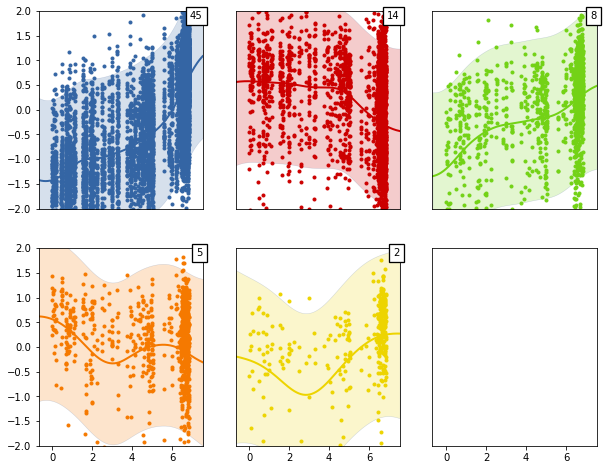

In [28]:
plt.figure(figsize=(10,8))
m_shalek_slicer.plot(on_subplots=True, colour=True, in_a_row=False, newfig=False,
                     min_in_cluster=1, joined=False, ylim=(-2,2))

# Simulation - SLICER

In [29]:
sim_expr, sim_slicer_times = \
    load_data("simSLICER.csv", "pseudoTimesSimSLICER.csv")
sim_lengthscale = sim_slicer_times[-1]  # Take last pseudotime as lengthscale
m_sim_slicer = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=sim_lengthscale,
                corruption_variance=.2,
                corruption_lengthscale=sim_lengthscale,
                noise_variance=.2,
                expression=sim_expr,
                times=sim_slicer_times)

FileNotFoundError: [Errno 2] No such file or directory: '../scratch/simSLICER.csv'

In [16]:
plt.figure(figsize=(18,18))
m_sim_slicer.plot(on_subplots=True, colour=True, in_a_row=False,
                  newfig=False, min_in_cluster=1, joined=False, ylim=(-2,2))
#this looks ugly, but the clusters are actually quite good

NameError: name 'm_sim_slicer' is not defined

# Simulation - DeLorean

In [ ]:
sim_expr, sim_DL_times = \
    load_data("simSLICER.csv", "pseudoTimesSimSLICER.csv")
sim_lengthscale = sim_DL_times[-1]  # Take final pseudotime as lengthscale
m_sim_DL = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=sim_lengthscale,
                corruption_variance=.2,
                corruption_lengthscale=sim_lengthscale,
                noise_variance=.2,
                expression=sim_expr,
                times=sim_DL_times)

In [ ]:
#the GPs don't look good, but the clusters are actually good
plt.figure(figsize=(10,8))
m_sim_DL.plot(on_subplots=True, colour=True, in_a_row=False,
              newfig=False, min_in_cluster=1, joined=False, ylim=(-2,2))
plt.savefig('Sim-DL.svg')